# Libraries and Environment

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import heapq
from scipy import spatial
from scipy.spatial import distance
from tqdm.notebook import tqdm, trange
import copy
import random
import cv2

# Table of Contents

1. Import Dataset
2. Vizualise CIFAR
3. Dimensionality Reduction on Image Feature Vectors
4. Data Structure Class Definitions
5. Populate Each Data Structure with CIFAR10 Data
6. Test Search Query Performance
7. Plotting and Batch Testing
8. Visual Examples

# 1. Import CIFAR10 Dataset

In [ ]:
colab = False

if not colab:
  DATA_ROOT = "/projectnb/ec504/students/kjv/FinalProject/input/cifar-10-batches-py/"
else:
  from google.colab import drive
  drive.mount('/content/drive')
  DATA_ROOT = "/content/drive/PATH_TO_FOLDER"

Note: Each row of the "images" array produced below stores one of the 60,000 32x32 color images. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.

In [ ]:
# function for unpickling the CIFAR10 dataset
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# import CIFAR10 image batches
batch1 = unpickle(DATA_ROOT + "data_batch_1")
batch2 = unpickle(DATA_ROOT + "data_batch_2")
batch3 = unpickle(DATA_ROOT + "data_batch_3")
batch4 = unpickle(DATA_ROOT + "data_batch_4")
batch5 = unpickle(DATA_ROOT + "data_batch_5")
test_batch = unpickle(DATA_ROOT + "test_batch")

images = np.concatenate([batch1[b'data'], batch2[b'data'], batch3[b'data'], batch4[b'data'], batch5[b'data'], test_batch[b'data']])

# convert image bytes to imgs
images_rgb = np.zeros((len(images), 32, 32, 3))
for i in range(len(images)):
  im = images[i]
  im_r = im[0:1024].reshape(32, 32)
  im_g = im[1024:2048].reshape(32, 32)
  im_b = im[2048:].reshape(32, 32)
  im_rgb = np.dstack((im_r, im_g, im_b)) / 255.0
  images_rgb[i,:,:,:] = im_rgb
  
images = images_rgb

# confirm correct size of data array
print("Data dimensions: ", np.shape(images))

Data dimensions:  (60000, 32, 32, 3)



# 2. Visualize CIFAR

In [ ]:
## functions for displaying cifar images

def cifar10_plot_single(data, im_idx=0):
    img = data[im_idx]    
    plt.imshow(img) 

def cifar10_plot_examples(data):
  
  for i in range(9):
    img = data[i]
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot 
    plt.imshow(img)

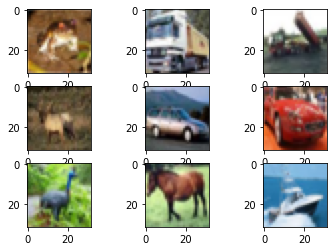

In [ ]:
cifar10_plot_examples(images)

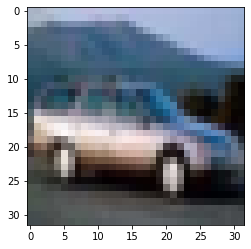

In [ ]:
cifar10_plot_single(images, im_idx=4)

# 3. Perform Dimensionality Reduction on Image Feature Vectors

In [ ]:
#Functions for PCA

# returns image feature vectors reduced to PCA component count in n_components
# also returns 'recovered' images for comparison, transformed from the reduced set back to original 32x32 space
def pca_reduce(images, n_components):
  pca = PCA(n_components = n_components)

  flat_grays = np.zeros((len(images), 1024))
  for i in range(len(images)):
    img = (images[i]*255).astype('uint8')
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    flat_grays[i] = gray.flatten()

  print(flat_grays.shape)
  images_reduced = pca.fit_transform(flat_grays)
  images_recovered = pca.inverse_transform(images_reduced)
  
  print("Image data reduced from: {} to {}".format(images.shape, images_reduced.shape))
  print()
  print("Explained variance ratio of each component: ")
  print(pca.explained_variance_ratio_)
  plt.plot(pca.explained_variance_ratio_)
  plt.show()
  plt.grid()
  plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
  plt.xlabel('Number of components')
  plt.ylabel('Explained variance')
  plt.show()
  
  return pca, images_reduced, images_recovered

# to inspect the PCA predicted images
def plot_pca_image(images, images_recovered, idx = 1):
    plt.subplot(1, 2, 1)
    cifar10_plot_single(images, im_idx= idx)
    plt.subplot(1, 2, 2)
    cifar10_plot_single(images_recovered.astype(int), im_idx = idx)
    plt.show()

(60000, 1024)
Image data reduced from: (60000, 32, 32, 3) to (60000, 100)

Explained variance ratio of each component: 
[0.30495241 0.12407202 0.07349322 0.0409553  0.03129289 0.03023718
 0.0240765  0.02290549 0.01621097 0.01450675 0.01194305 0.01176234
 0.0112038  0.01029701 0.00911463 0.00793329 0.00724078 0.00662753
 0.00658542 0.00554687 0.0055229  0.0052274  0.0050645  0.00501015
 0.0044929  0.00445881 0.0040972  0.00377078 0.00362951 0.00348264
 0.00343243 0.00326535 0.0029279  0.00291042 0.00284955 0.00278554
 0.00272804 0.00257789 0.00255832 0.00248114 0.00236725 0.0023116
 0.00216338 0.00213573 0.00205927 0.00203253 0.00195406 0.00192038
 0.00181764 0.00178561 0.00175051 0.00174004 0.00168514 0.00164485
 0.00160209 0.00158818 0.00153893 0.00150936 0.00149354 0.00144647
 0.00139332 0.00136225 0.00135795 0.00127637 0.00126532 0.00125597
 0.00124302 0.00117571 0.00116306 0.0011423  0.00112224 0.00111334
 0.00109961 0.00108839 0.00104816 0.00104022 0.00101539 0.00099656
 0.0009876

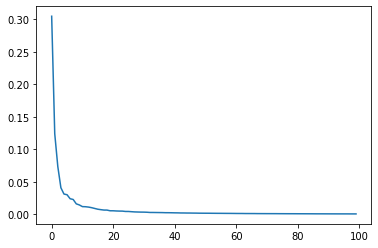

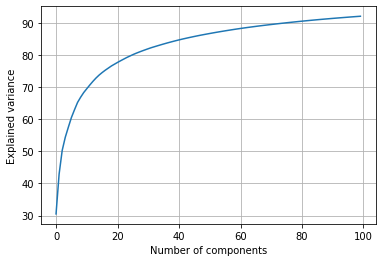

In [ ]:
# change "dimensions" value to specify the number of features you would like to reduce each image to
dimensions = 100 
pca, images_reduced, images_recovered = pca_reduce(images, dimensions)

# 4. Data Structure Class Definitions

## kd-Tree

In [ ]:
class kdNode:
  """
  Nodes used to store data in the kd-tree.

  data_idx: the row index of the image represented by the node in the tree's dataset
  discriminator: the feature dimension used to split the kd-tree at the node's level
  """
  def __init__(self, data_idx, discriminator, lchild=None, rchild=None):
    self.data_idx = data_idx
    self.discriminator = discriminator
    self.lchild = lchild
    self.rchild = rchild
    
  def __repr__(self):
    return f"Node with Index {self.data_idx}"


class knnHeapNode:
  """
  Object used to keep track of kNNs during kdTree.find_kNN()
  """
  def __init__(self, kdnode, L2Dist):
    self.node = kdnode
    self.L2Dist = L2Dist

  # override the less-than operator to change heapq from min heap to max heap when made of knnHeapNodes
  def __lt__(self, other):
    return self.L2Dist > other.L2Dist

  def __repr__(self):
    return f"(Node Index: {self.node.data_idx}, L2 Distance: {self.L2Dist})"


class kdTree:
  
  def __init__(self):
    self.root = None
    self.data = None

  def builder(self, data, discriminator=0):
    """
    Called by the build_tree function to construct the kd-tree
    """

    num_samples = len(data)
    kdim = len(data[0][1])
    median_idx = num_samples // 2
    
    # sort data according to feature column indexed by discriminator
    data = sorted(data, key=lambda x: x[1][discriminator])

    # find first occurrence of median value for discriminator dimension
    median = data[median_idx][1][discriminator]

    while median_idx > 0 and median == data[median_idx-1][1][discriminator]:
      median_idx = median_idx-1

    # create root node for tree
    node = kdNode(data_idx=data[median_idx][0], discriminator=discriminator)

    # calculate discriminator index for next level
    next_discriminator = (discriminator + 1) % kdim

    # add left subtree containing vectors[discriminator] < median and right subtree containing vectors[discriminator] >= median to root
    if median_idx > 0:
      node.lchild = self.builder(data[:median_idx], next_discriminator)
    if num_samples - (median_idx + 1) > 0:
      node.rchild = self.builder(data[median_idx+1:], next_discriminator)

    return node

  def build_tree(self, data):
    """
    Called by the user to initialize the kd-tree using the provided dataset
    """
    self.data = copy.deepcopy(data)
    self.root = self.builder(data)

  def find_kNN(self, k, query_vec, node=None, kNN=None):
    """
    Find and return a list of the query_vec's k nearest neighbors in the tree's dataset
    
    NOTE: kNN is returned as a max heap of knnHeapNodes, so in order to get the 
    final list in increasing order of L2 dist, the final output must be reverse-sorted 
    using sorted(kNN, reverse=True)
    """
    
    if node == None:
      node = self.root
    
    # create max heap for tracking node values and associated L2 distances of k nearest neighbors
    if kNN == None:
      kNN = []
      heapq.heapify(kNN)

    # extract feature vector from tuple in reference data
    feat_vec = self.data[node.data_idx][1]

    # calculate L2 distance between query_vec and the current node
    dist = distance.euclidean(query_vec, feat_vec)

    if len(kNN) < k:
      heapq.heappush(kNN, knnHeapNode(node, dist))
    else:
      if dist < kNN[0].L2Dist:
        heapq.heapreplace(kNN, knnHeapNode(node, dist))

    # determine best direction to traverse tree
    discriminator = node.discriminator

    if query_vec[discriminator] < feat_vec[discriminator]:
      good_side = node.lchild
      bad_side = node.rchild
    else:
      good_side = node.rchild
      bad_side = node.lchild

    # traverse good side
    if good_side != None:
      kNN = self.find_kNN(k, query_vec, node=good_side, kNN=kNN)

    # determine if the bad side is worth exploring by checking the possibility of a shorter distance to the query on the bad side
    if bad_side != None and abs(query_vec[discriminator] - feat_vec[discriminator]) < kNN[0].L2Dist:
      kNN = self.find_kNN(k, query_vec, node=bad_side, kNN=kNN)

    # return max heap of k closest nodes
    return kNN

## Locality hashing

For our locality hashing we used for reference the following github repository (also cited in report):
https://github.com/kayzhu/LSHash/blob/master/lshash/lshash.py


In [ ]:
class LocalityHash:

  def __init__(self, hash_size, input_dim, num_tables = 1):
      
      """
        arg input_dim: the expected dimension of the data to be hashed
        arg hash_size: number of random hyperplanes that divide the space into hash buckets
        
        Info: What we are realy storing for hyperplanes is the norm of the planes, initialized randomly with standard normal distribution. 
        Points whose dot product with the norm have the same sign are on the same side of the plane.
      """
      self.hash_size = hash_size
      self.input_dim = input_dim
      self.num_tables = num_tables

      self.planes = [np.random.randn(self.hash_size, self.input_dim) for _ in range(self.num_tables)]
      self.hash_tables = [{} for _ in range(self.num_tables)]

      print("LSH initialized")
      print("Number of hash tables: {}".format(self.num_tables))
      print("Number of hyperplanes per table: {}".format(self.hash_size))
      print("Number of buckets per table: {}".format(2**(self.hash_size)))
  
  def get_hashkey(self, plane, input_point):

    """ 
      arg input point dimension = 1* input_dim

      Takes an input point and generates a hash key based on its location relative to the hyperplanes (In which bucket)
      Returns a binary string map of length self.hash_size (number of hyperplanes) where 1 = "above" hyperplane i and 0 = "below" hyperplane i
      looks like: "101010100"

    """
    location_projections = np.dot(plane, np.array(input_point))
        
    #if dot product of input point and hyper plane is positive, it's 'above' in n-d space, if negative or 0, below
    hash_key = "".join(['1' if i > 0 else '0' for i in location_projections])

    return hash_key


  def insert_point(self, input_point, original_index):

    """
      arg input_point dimension = 1* input_dim
      arg original_index = reference to the index of the full size image for retrieval
    """

    info = (tuple(input_point), original_index)  #save point as tuple to save memory
    
    for i, hash_table in enumerate(self.hash_tables):
      key = self.get_hashkey(self.planes[i], input_point)

      if key in hash_table:
          hash_table[key].append(info)
      else:
          hash_table[key] = [info]

  
  def initialize(self, input_data, verbose = False):
    if len(input_data[0][1]) != self.input_dim:
        print("Input points should have dimension: 1 x {}".format(self.input_dim))
        return

    print("Initializing LSH from data...")

    for data in input_data:
      index, point = data
      self.insert_point(point, index)

    if verbose:
      count_str = "\nInserted:\n"
      for i, hash_table in enumerate(self.hash_tables):
        for bucket, item in hash_table.items():
            count_str += "{} items into bucket {} in hash table {}".format(str(len(item)), bucket, str(i+1))
            count_str += "\n"
        count_str += "\n"

      print(count_str)


  def get_knns(self, query_point, k, remove_first = False):
      
      candidates = set()
      start = time.time()
      for i, table in enumerate(self.hash_tables):
          key = self.get_hashkey(self.planes[i], query_point)
          if key in table:
            candidates.update(table[key])
      end = time.time()

      if len(candidates) <= 1:  #if query returns nothing or just the query point itself, return
        if len(candidates) == 0 or (tuple(candidates[0][0]) == tuple(query_point.tolist())):
          print("No neighbors found")
          return
  
      start = time.time()
      candidates_aug = []
      #add euclidean
      for i, (point, index) in enumerate(candidates):
          dist = distance.euclidean(query_point, point)
          candidates_aug.append((point, index, dist))
      end = time.time()
      print("Time spent in calculating distances: ", end-start)

      #sort on euclidean
      candidates_aug.sort(key=lambda x: x[2])

      ##trim if duplicates/remove same value:
      if remove_first:
        smallest_dist = candidates_aug[0][2]
        i = 0
        while i < len(candidates_aug) and smallest_dist == 0:
          candidates_aug = candidates_aug[i+1:]
          smallest_dist = candidates_aug[0][2]

      if len(candidates_aug) <= k:
        return candidates_aug
      else:
        return candidates_aug[:k]


# 5. Populate Each Data Structure with CIFAR10 Data

In [ ]:
# format data for input into kd tree
ids = np.arange(images_reduced.shape[0])
images_reduced_ids = list(zip(list(ids), list(images_reduced)))

In [ ]:
#original data for lsh
images_flat = np.concatenate([batch1[b'data'], batch2[b'data'], batch3[b'data'], batch4[b'data'], batch5[b'data'], test_batch[b'data']])
images_rgb = np.zeros((len(images), 32, 32, 3))
for i in range(len(images_flat)):
  im = images_flat[i]
  im_r = im[0:1024].reshape(32, 32)
  im_g = im[1024:2048].reshape(32, 32)
  im_b = im[2048:].reshape(32, 32)
  im_rgb = np.dstack((im_r, im_g, im_b)) / 255.0
  images_rgb[i,:,:,:] = im_rgb
images_flat = images_rgb
flat_grays = np.zeros((len(images), 1024))
for i in range(len(images)):
    img = (images_flat[i]*255).astype('uint8')
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    flat_grays[i] = gray.flatten()
images_flat = flat_grays
images_tupled = []
for i, img in enumerate(images_flat):
  images_tupled.append((i, img))

In [ ]:
cifar_kdtree = kdTree()
cifar_kdtree.build_tree(images_reduced_ids)

if 'lsh' in globals():
    del lsh
    
#INITIALIZE LSH
hash_size = 14
num_tables = 2
lsh = LocalityHash(hash_size = hash_size , input_dim = images_flat.shape[1], num_tables = num_tables)
lsh.initialize(images_tupled)

LSH initialized
Number of hash tables: 2
Number of hyperplanes per table: 14
Number of buckets per table: 16384
Initializing LSH from data...


# 6. Test Search Query Performance

## Helper Functions

In [ ]:
def get_ground_truth_nns(query, num_kNN, data):
  """
  Brute force computation of the query's nearest neighbors in data matrix using L2 norm.
  
  Assumes data is a list of tuples of the form [(image_index, [features])].

  Returns list of tuples of the form [(image_index, L2Dist)], with tuples
  ordered from smallest L2 distance to largest L2 distance
  """
  # compute ground truth nn for query image
  true_nns = []
  for i, row in enumerate(data):
    dist = distance.euclidean(query, row)

    if len(true_nns) < num_kNN:
      true_nns.append((i, dist))
    else:
      biggest_dist = max(true_nns, key=lambda x:x[1])
      if dist < biggest_dist[1]:
        max_index = true_nns.index(biggest_dist)
        true_nns[max_index] = (i,dist)

  true_nns.sort(key=lambda x: x[1])
  return true_nns

## kd-Tree:

In [ ]:
import time
from operator import eq

sum = 0
sum2 = sum
del sum

#num_neighbors = int(input("How many nearest neighbors for your image query?: "))
num_neighbors = 100

# chose random query image
rand_index = random.randint(0, len(images_flat))
query_image = images_flat[rand_index,:]
reduced_query = images_reduced[rand_index,:]

print("Query image: ")
#cifar10_plot_single(images, rand_index)
#del images

start = time.time()
true_nns = get_ground_truth_nns(query_image, num_neighbors, images_flat)
end = time.time()

print("naive benchmark: {}".format(end - start))

exemplars = []
exemplars_neighbor_list = []
for x in true_nns:
  exemplars.append(int(x[0]))
  exemplars_neighbor_list.append(str(x[0]))

print(exemplars)

'''for neighbor in exemplars:
  print(distance.euclidean(query_image, images_og[neighbor]))'''

start = time.time()
# find kNN for query image using kdTree
knn_kd = cifar_kdtree.find_kNN(k=num_neighbors, query_vec=reduced_query)
knn_kd = sorted(knn_kd, reverse=True)
end = time.time()

# reduced neighbor distances
kd_neighbor_list = []
# true non-reduced distancesretrieving candidates:  0.34514570236206055

for neighbor in knn_kd:
  kd_neighbor_list.append(int(str(neighbor.node).replace("Node with Index ", "")))

print(kd_neighbor_list)
print("kd benchmark: {}".format(end - start))

commons = 0 
for i in range(len(kd_neighbor_list)):
  for j in range(len(exemplars)):
    if kd_neighbor_list[i] == exemplars[j]:
      commons += 1

print("kd accuracy percentage {}%".format(100*commons/num_neighbors))


## Locality Sensitive Hashing

In [ ]:
import time
from operator import eq

sum = 0
sum2 = sum
del sum

start = time.time()
knn_lsh = lsh.get_knns(query_image, num_neighbors)
end = time.time()

lsh_neighbor_list = []
# true non-reduced distances
for neighbor in knn_lsh:
  #print(distance.euclidean(query_image, images_flat[int(neighbor[1])]))
  lsh_neighbor_list.append(int(neighbor[1]))

# neighbor distances
print(exemplars)
print(lsh_neighbor_list)

### DO STUFF
print("lsh benchmark: {}".format(end - start))
commons = 0 
for i in range(len(lsh_neighbor_list)):
  for j in range(len(exemplars)):
    if lsh_neighbor_list[i] == exemplars[j]:
      commons += 1
print("lsh accuracy percentage {}%".format(100*commons/num_neighbors))


# 7. Plotting and Batch Testing

1
naive benchmark: 1.5516462326049805
kd benchmark: 0.45494985580444336
kd accuracy percentage 76.0%
Time spent in calculating distances:  0.05992746353149414
lsh benchmark: 0.07874178886413574
lsh accuracy percentage 8.0%
2
naive benchmark: 1.5077564716339111
kd benchmark: 0.8761627674102783
kd accuracy percentage 74.0%
Time spent in calculating distances:  1.4036462306976318
lsh benchmark: 1.8689460754394531
lsh accuracy percentage 71.0%
3
naive benchmark: 1.5117990970611572
kd benchmark: 0.9039270877838135
kd accuracy percentage 82.0%
Time spent in calculating distances:  0.23073768615722656
lsh benchmark: 0.33654093742370605
lsh accuracy percentage 21.0%
4
naive benchmark: 1.4720642566680908
kd benchmark: 0.8888163566589355
kd accuracy percentage 76.0%
Time spent in calculating distances:  0.31901001930236816
lsh benchmark: 0.4633064270019531
lsh accuracy percentage 39.0%
5
naive benchmark: 1.5260045528411865
kd benchmark: 0.8888483047485352
kd accuracy percentage 83.0%
Time spent 

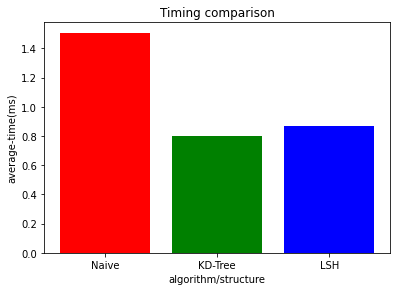

['Naive', 'KD-Tree', 'LSH']
[100.0, 82.34, 40.95]


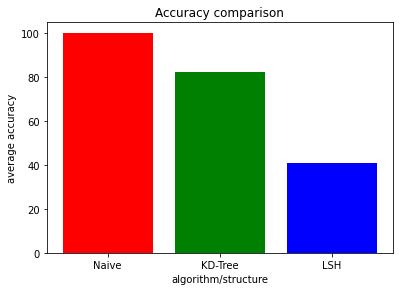

In [ ]:
import time
from operator import eq

def plot(data_points, title, xlabel, ylabel):
    fig = plt.figure()
    ax = fig.add_axes([0.12,0.1,0.8,0.8])
    algos = ['Naive', 'KD-Tree', 'LSH']
    print(algos)
    print(data_points)
    ax.bar(algos, data_points, color=['red', 'green', 'blue'])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.show()
  
naive_times = []
kd_times = []
lsh_times = []

naive_acc = []
kd_acc = []
lsh_acc = []

trial_count = 0

for i in range(100):
  trial_count += 1
  print(trial_count)
  sum = 0
  sum2 = sum
  del sum

  num_neighbors = 100

  # chose random query image
  rand_index = random.randint(0, len(images_flat))
  query_image = images_flat[rand_index,:]
  reduced_query = images_reduced[rand_index,:]

  start = time.time()
  true_nns = get_ground_truth_nns(query_image, num_neighbors, images_flat)
  end = time.time()
  naive_benchmark = end - start
  naive_times.append(naive_benchmark)
  print("naive benchmark: {}".format(end - start))

  exemplars = []
  exemplars_neighbor_list = []
  for x in true_nns:
    exemplars.append(int(x[0]))
    exemplars_neighbor_list.append(str(x[0]))
  naive_acc.append(100)

  start = time.time()
  # find kNN for query image using kdTree
  knn_kd = cifar_kdtree.find_kNN(k=num_neighbors, query_vec=reduced_query)
  end = time.time()
  knn_kd = sorted(knn_kd, reverse=True)

  # reduced neighbor distances
  kd_neighbor_list = []
  # true non-reduced distancesretrieving candidates:  0.34514570236206055

  for neighbor in knn_kd:
    kd_neighbor_list.append(int(str(neighbor.node).replace("Node with Index ", "")))
  kd_benchmark =  end - start
  print("kd benchmark: {}".format(end - start))
  kd_times.append(kd_benchmark) 

  commons = 0 
  for i in range(len(kd_neighbor_list)):
    for j in range(len(exemplars)):
      if kd_neighbor_list[i] == exemplars[j]:
        commons += 1
  kd_percentage = 100*commons/num_neighbors
  kd_acc.append(kd_percentage)
  print("kd accuracy percentage {}%".format(100*commons/num_neighbors))

  start = time.time()
  knn_lsh = lsh.get_knns(query_image, num_neighbors)
  end = time.time()

  lsh_neighbor_list = []
  # true non-reduced distances
  for neighbor in knn_lsh:
    lsh_neighbor_list.append(int(neighbor[1]))
  lsh_benchmark = end - start
  lsh_times.append(lsh_benchmark)
  print("lsh benchmark: {}".format(end - start))
  
  commons = 0 
  for i in range(len(lsh_neighbor_list)):
    for j in range(len(exemplars)):
      if lsh_neighbor_list[i] == exemplars[j]:
        commons += 1
  lsh_percentage = 100*commons/num_neighbors
  lsh_acc.append(lsh_percentage)
  print("lsh accuracy percentage {}%".format(100*commons/num_neighbors))

average_timings = [sum(naive_times)/len(naive_times), sum(kd_times)/len(kd_times), sum(lsh_times)/len(lsh_times)]
average_accs = [sum(naive_acc)/len(naive_acc), sum(kd_acc)/len(kd_acc), sum(lsh_acc)/len(lsh_acc)]

plot(average_timings, "Timing comparison", "algorithm/structure", "average-time(ms)")
plot(average_accs, "Accuracy comparison", "algorithm/structure", "average accuracy")

# 9. Visual Examples of Results

In [ ]:
def plot_knn_examples(neighbor_list, images):
  
  for i in range(9):
    index = neighbor_list[i]
    img = images[index]
    
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot 
    plt.imshow(img)
    if i == 0:
      plt.title("Original image")
    else:
      plt.title('{}.'.format(i))
    
  plt.tight_layout()


True nearest neighbors



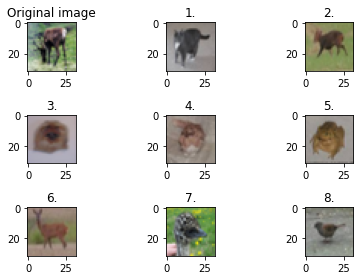

In [ ]:
print()
print("True nearest neighbors")
print()
plot_knn_examples(exemplars, images)


Nearest neighbors returned by kd tree



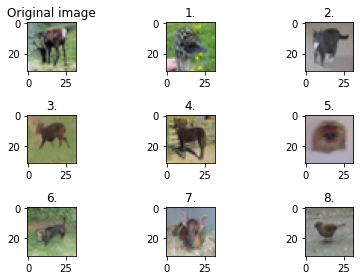

In [ ]:
print()
print("Nearest neighbors returned by kd tree")
print()
plot_knn_examples(kd_neighbor_list, images)


Nearest neighbors neturned by lsh



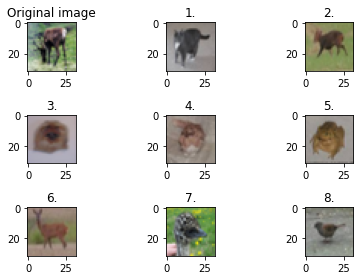

In [ ]:
print()
print("Nearest neighbors neturned by lsh")
print()
plot_knn_examples(lsh_neighbor_list, images)